In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, Subset
from torch import nn
from torchvision.transforms.functional import convert_image_dtype
from scipy.interpolate import CubicSpline
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import gc

In [2]:

# Paths to data
path_kp = "data_files/kp_data.txt"
path_img_specs = "data_files/image_specs.csv"
img_dir = "data_files/solar_images"

# Load kp data
data_kp = pd.read_csv(path_kp)
data_kp["datetime"] = pd.to_datetime(data_kp["datetime"])

# Load image specs data
img_specs = pd.read_csv(path_img_specs)
img_specs["datetime"] = pd.to_datetime(img_specs["datetime"])

image_filenames = img_specs["filename"].values
image_dates = img_specs["datetime"].values


# Converting datetimes to integer timestamps in seconds
image_timestamps = image_dates.astype("int64") // 10**9
kp_timestamps = data_kp["datetime"].values.astype("int64") // 10**9
kp_index_interpolated = CubicSpline(kp_timestamps, data_kp["Kp"].values)(
    image_timestamps
)

data_merged = pd.DataFrame(
    {
        "Timestamp": image_timestamps,
        "Image_filename": image_filenames,
        "Kp": kp_index_interpolated,
    }
)

day = 24 * 60 * 60
year = 365.2425 * day
# Synodic carrington rotation of sun
cycle = 27.2753 * day

data_merged["day_sin"] = np.sin(image_timestamps * (2 * np.pi / day))
data_merged["day_cos"] = np.cos(image_timestamps * (2 * np.pi / day))
data_merged["cycle_sin"] = np.sin(image_timestamps * (2 * np.pi / cycle))
data_merged["cycle_cos"] = np.cos(image_timestamps * (2 * np.pi / cycle))
data_merged["year_sin"] = np.sin(image_timestamps * (2 * np.pi / year))
data_merged["year_cos"] = np.cos(image_timestamps * (2 * np.pi / year))

# Scaling the numerical data
timestamp_scaler = MinMaxScaler(feature_range=(-1, 1))

data_merged["Kp"] = (data_merged["Kp"]>=5).astype(int)
data_merged["Timestamp"] = timestamp_scaler.fit_transform(
    data_merged["Timestamp"].values.reshape(-1, 1)
)


def create_sequence(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        feature = data.iloc[i : i + seq_length]
        target = data.iloc[i + seq_length]["Kp"]
        sequences.append((feature, target))
    return sequences


class ImageAndKpDataset(Dataset):
    def __init__(self, sequences, img_dir, img_transform):
        self.sequences = sequences
        self.img_transform = img_transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.sequences)

    def read_and_transform_image(self, path):
        return self.img_transform(read_image(path).cuda().float())

    def __getitem__(self, idx):
        features, target = self.sequences[idx]
        image_paths = [
            os.path.join(self.img_dir, path)
            for path in features["Image_filename"].values
        ]
        features = features.drop(columns=["Image_filename"])
        numerical_features = torch.tensor(features.values, dtype=torch.float32).cuda()
        target = torch.tensor(target, dtype=torch.float32).cuda().unsqueeze(-1)
        with ThreadPoolExecutor() as executor:
            images = list(executor.map(self.read_and_transform_image, image_paths))
        images = torch.stack(images)
        return images, numerical_features, target


seq_length = 7
sequences = create_sequence(data_merged, seq_length)
# img_transform = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
img_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
dataset = ImageAndKpDataset(sequences, img_dir, img_transform)

# Split training data into training and validation data:
full_len = len(dataset)
train_frac = 0.8
train_size = int(full_len * train_frac)
train_data = Subset(dataset, range(0, train_size))
val_data = Subset(dataset, range(train_size, full_len))

In [4]:
class SolarImageKpModel(nn.Module):
    def __init__(self):
        super().__init__()

        # CNN for the solar images
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 64 * 32, 4)

        # RNN for the image data
        self.lstm_img = nn.LSTM(
            input_size=4, hidden_size=32, num_layers=1, batch_first=True
        )

        # Fully-connected layers for the numerical data (8 input features)
        self.fc_num1 = nn.Linear(8, 16)
        self.fc_num2 = nn.Linear(16, 32)

        # RNN for the numerical data
        self.lstm_num = nn.LSTM(
            input_size=32, hidden_size=32, num_layers=1, batch_first=True
        )

        # Fully-connected layer that combines the image and numerical data to make the final prediction
        self.fc_final = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x_img, x_num):
        batch_size, seq_length, _, _, _ = x_img.size()

        # Perform CNN
        cnn_features = []
        for i in range(seq_length):
            img = x_img[:, i, :, :, :]
            img = self.pool(F.relu(self.conv1(img)))
            img = self.pool(F.relu(self.conv2(img)))
            img = self.pool(F.relu(self.conv3(img)))
            img = img.view(batch_size, -1)
            img = F.relu(self.fc1(img))
            cnn_features.append(img)

        # Putting the CNN features together so we can pass them to the RNN
        cnn_features = torch.stack(cnn_features, dim=1)

        rnn_out_img, _ = self.lstm_img(cnn_features)

        # We take the last time step from the RNN
        rnn_out_img = rnn_out_img[:, -1, :]

        # The two fully-connected layers for the numerical features
        x_num = F.relu(self.fc_num1(x_num))
        x_num = F.relu(self.fc_num2(x_num))

        # RNN for the numerical features
        rnn_out_num, _ = self.lstm_num(x_num)
        rnn_out_num = rnn_out_num[:, -1, :]

        # Combining the CNN and numerical features RNN output
        combined_rnn = torch.cat((rnn_out_img, rnn_out_num), dim=1)

        # Final fully-connected layer
        out = self.sigmoid(self.fc_final(combined_rnn))

        return out


In [5]:
n_seq = 0
num_forecast_steps = 8
model = torch.load("Models/image_classification_smallmodel80.pth")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
n_forward = int(full_len * (1-train_frac))
target_arr = []
pred_arr = []
with torch.no_grad():
    for i in range(n_forward):
            img, num_feats, target = val_data[i]
            img, num_feats = img.to(device).unsqueeze(0), num_feats.to(device).unsqueeze(0)
            target = target.item()
            target_arr.append(target)
            pred = model(img, num_feats)
            pred_arr.append(pred.item())
target_arr = np.array(target_arr).reshape(-1, 1)
pred_arr = np.array(pred_arr).reshape(-1, 1)
target_arr = target_arr.ravel()
pred_arr = pred_arr.ravel()

In [35]:
n_forward = int(full_len *train_frac)
target_arr_train = []
pred_arr_train = []
with torch.no_grad():
    for i in tqdm(range(n_forward)):
            img, num_feats, target = train_data[i]
            img, num_feats = img.to(device).unsqueeze(0), num_feats.to(device).unsqueeze(0)
            target = target.item()
            target_arr_train.append(target)
            pred = model(img, num_feats)
            pred_arr_train.append(pred.item())
target_arr_train = np.array(target_arr_train).reshape(-1, 1)
pred_arr_train = np.array(pred_arr_train).reshape(-1, 1)
target_arr_train = target_arr_train.ravel()
pred_arr_train = pred_arr_train.ravel()

100%|████████████████████████████████████████████████████████████████████████████| 32028/32028 [11:03<00:00, 48.26it/s]


In [52]:
from sklearn.metrics import roc_auc_score, roc_curve
import scienceplots

In [36]:
score = roc_auc_score(target_arr, pred_arr)
print(score)

score_train = roc_auc_score(target_arr_train, pred_arr_train)
print(score_train)

0.7006943664374301
0.9467961863981639


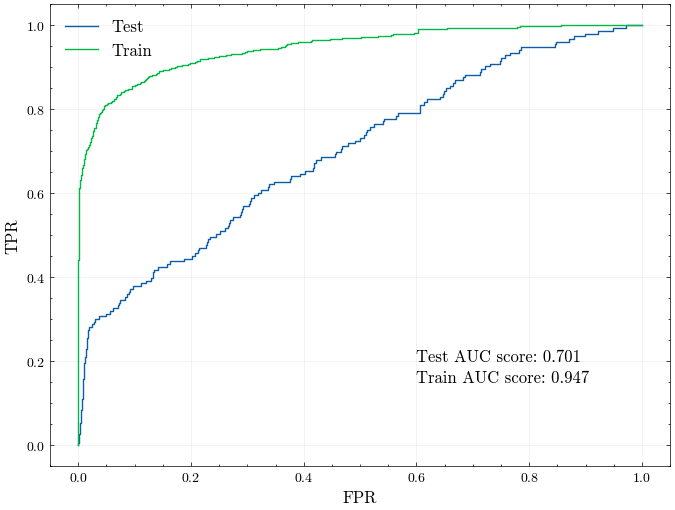

In [46]:
fig = plt.figure(figsize=(8, 6))
plt.style.use(["science", "no-latex"])
fpr, tpr, _ = roc_curve(target_arr, pred_arr)
fpr_train, tpr_train, _ = roc_curve(target_arr_train, pred_arr_train)

plt.plot(fpr, tpr, label="Test")
plt.plot(fpr_train, tpr_train, label="Train")
plt.text(0.6, 0.2, "Test AUC score: {}".format(round(score, 3)), fontsize=12)
plt.text(0.6, 0.15, "Train AUC score: {}".format(round(score_train, 3)), fontsize=12)
plt.legend(loc="upper left", fontsize=12)
plt.xlabel("FPR", fontsize=12)
plt.ylabel("TPR", fontsize=12)
plt.grid(alpha=0.2)
plt.savefig("Plots/80pct_50epoch_smallmodel_classification_ROC.png", dpi=200)

In [93]:
train_test_history_path = "data_files/classification_80pct_50epochs_small_batch8"
train_hist = np.genfromtxt(train_test_history_path + "/train_history.csv", delimiter=",", skip_header=1).T
test_hist = np.genfromtxt(train_test_history_path + "/test_history.csv", delimiter=",", skip_header=1).T

In [97]:
(train_hist[0]).astype(int)+1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

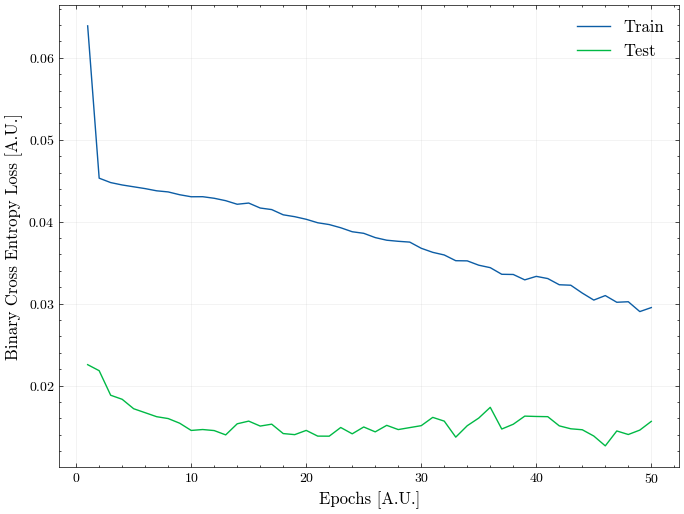

In [102]:
fig = plt.figure(figsize=(8, 6))
plt.plot((train_hist[0]).astype(int)+1, train_hist[1], label="Train")
plt.plot((test_hist[0]).astype(int)+1, test_hist[1], label="Test")
plt.xlabel("Epochs [A.U.]", fontsize=12)
plt.ylabel("Binary Cross Entropy Loss [A.U.]", fontsize=12)
plt.grid(alpha=0.2)
plt.legend(fontsize=12)
plt.savefig("Plots/80pct_50epochs_smallmodel_classification_train_test_loss.png", dpi=200)
